In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
data_folder = 'expr_data'

In [3]:
import time
t = time.time()

## Environment Setup (for Colab)

In [ ]:
from datetime import datetime

os.chdir('/content')
current_time = datetime.utcnow().isoformat().replace(':', '_')
os.makedirs(os.path.join(current_time))
os.chdir(f'./{current_time}')
WORKSPACE = 'anonify'

!git clone https://github.com/lng-ng/anonify.git

os.chdir(f'./{WORKSPACE}')

!pip install bigtree

## Run the experiment

In [4]:
import numpy as np
import pandas as pd
import os
import tqdm
import matplotlib.pyplot as plt
from datetime import datetime
from stratified_sampling import random_deletion

In [5]:
SA_NAMES = ['hypertension', 'heart_disease', 'smoking_history', 'HbA1c_level', 'blood_glucose_level', 'diabetes']
QID_NAMES = ['gender', 'age', 'bmi']
# Load dataset
load_path = os.path.join(data_folder, 'diabetes_anonymized_arx250.csv')
df = pd.read_csv(load_path)

In [6]:
old_size = df.groupby(QID_NAMES).size()

# Risk and certainty calculation for the original, anonymized dataset
metrics = ["AverageRisk%", "MinRisk%", "MaxRisk%", "AverageCertainty%", "MinCertainty%", "MaxCertainty%"]
res_df = pd.DataFrame()
anon_values = [
    (len(old_size) / len(df)) * 100, 
    (1/old_size).min() * 100,
    (1/old_size).max() * 100,
    100,
    100,
    100
]
res_df.insert(0, "250-Anonymized", pd.Series(data=anon_values, index=metrics))

# Risk and certainty calculation for the sampled datasets at different sampling percentages
ps = [0.1, 0.3, 0.5, 0.7]
for p in ps:
    print(f"Sampling the dataset, p={p}")
    avg_res = []
    for i in tqdm.tqdm(range(10)):
        sampled_df = random_deletion(df, p, QID_NAMES)
        new_size = sampled_df.groupby(QID_NAMES).size()
        tmp = old_size.to_frame(name="old_size")
        tmp.insert(1, "new_size", new_size)
        
        avg_risk = ((tmp['new_size'] * 1/tmp['old_size']).sum() / len(df)) * 100
        avg_certainty = (tmp['new_size'].sum() / len(df)) * 100
        min_risk = 0 if (old_size != new_size).any() else (1/old_size).min() * 100
        max_risk = 0 if (new_size == 0).all() else (1/old_size).max() * 100
        min_certainty = (tmp['new_size'] / tmp['old_size']).min() * 100
        max_certainty = (tmp['new_size'] / tmp['old_size']).max() * 100

        avg_res.append([avg_risk, min_risk, max_risk, avg_certainty, min_certainty, max_certainty])
        
    values = np.asarray(avg_res).mean(axis=0)
    res_df.insert(len(res_df.columns), f'{p}-Deletion', pd.Series(data=values, index=metrics))

Sampling the dataset, p=0.1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:10<00:00,  1.09s/it]


Sampling the dataset, p=0.3


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:09<00:00,  1.00it/s]


Sampling the dataset, p=0.5


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:09<00:00,  1.10it/s]


Sampling the dataset, p=0.7


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:08<00:00,  1.21it/s]


In [7]:
res_df

,250-Anonymized,0.1-Deletion,0.3-Deletion,0.5-Deletion,0.7-Deletion
AverageRisk%,0.191000,0.171684,0.133486,0.095365,0.057075
MinRisk%,0.055006,0.000000,0.000000,0.000000,0.000000
MaxRisk%,3.448276,3.448276,3.448276,3.448276,3.448276
AverageCertainty%,100.000000,89.911000,69.914000,49.949000,29.914000
MinCertainty%,100.000000,89.641434,68.965517,48.275862,27.586207
MaxCertainty%,100.000000,90.000000,70.000000,50.000000,30.000000


### Figure 11: Journalist risk (𝑘=250).

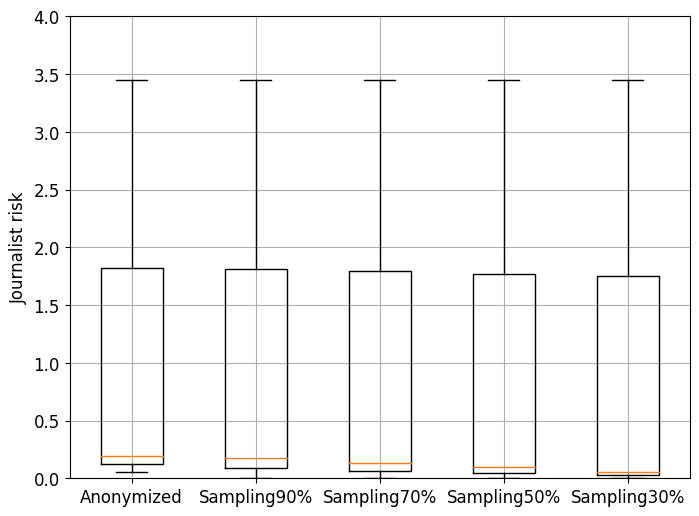

In [8]:
# Data
categories = ['Anonymized', 'Sampling90%', 'Sampling70%', 'Sampling50%', 'Sampling30%']

Anonymized = res_df['250-Anonymized'][:3]
Deletion10 = res_df['0.1-Deletion'][:3]
Deletion30 = res_df['0.3-Deletion'][:3]
Deletion50 = res_df['0.5-Deletion'][:3]
Deletion70 = res_df['0.7-Deletion'][:3]

# Create a boxplot
plt.figure(figsize=(8, 6))
plt.boxplot([Anonymized, Deletion10, Deletion30, Deletion50, Deletion70], labels=['Anonymized', 'Sampling90%', 'Sampling70%', 'Sampling50%', 'Sampling30%'])
#plt.title('')
#plt.xlabel('Categories')
plt.ylabel('Journalist risk', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(0, 4)
# Show the plot
plt.grid(True)
plt.show()


### Figure 12: Certainty (𝑘=250).

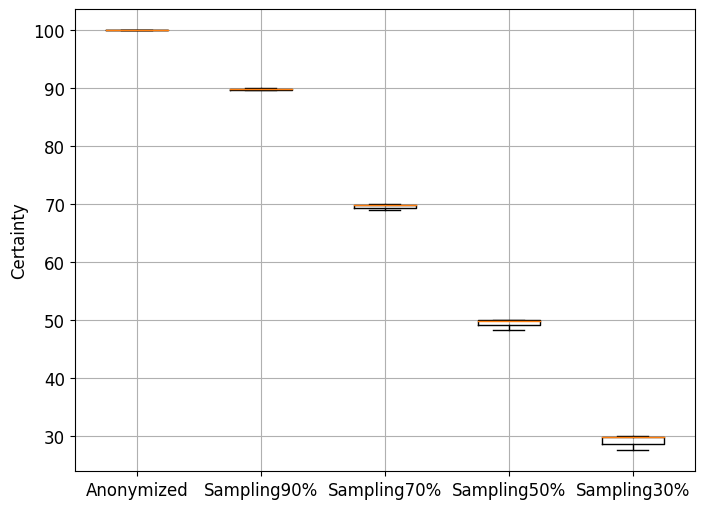

In [9]:
# Data
categories = ['Anonymized', 'Sampling90%', 'Sampling70%', 'Sampling50%', 'Sampling30%']

Anonymized  = res_df['250-Anonymized'][3:]   
Deletion10  = res_df['0.1-Deletion'][3:]   
Deletion30  = res_df['0.3-Deletion'][3:]   
Deletion50  = res_df['0.5-Deletion'][3:]   
Deletion70  = res_df['0.7-Deletion'][3:]   

# Create a boxplot
plt.figure(figsize=(8, 6))
plt.boxplot([Anonymized, Deletion10, Deletion30, Deletion50, Deletion70], labels=['Anonymized', 'Sampling90%', 'Sampling70%', 'Sampling50%', 'Sampling30%'])
#plt.title('')
#plt.xlabel('Categories')
plt.ylabel('Certainty', fontsize=12)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

#plt.ylim(0, 4)
# Show the plot
plt.grid(True)
plt.show()

In [10]:
# cleanup data folder
#import shutil
#shutil.rmtree(data_folder)

In [11]:
print(f"Time taken: {time.time() - t}")

Time taken: 44.169692516326904
